<a href="https://colab.research.google.com/github/sierra-hunt/github-and-kaggle-ML-work/blob/main/NLP_Sentiment_Analysis_on_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP project performs sentiment analysis on Twitter data

This coursework project implements a comprehensive Natural Language Processing pipeline for Twitter sentiment analysis across three classes (positive, neutral, negative).

It begins with balanced dataset preparation and progresses through multiple analysis techniques: K-means clustering on TF-IDF vectors to discover topic patterns, comparative evaluation of traditional classifiers (Logistic Regression, SVM, Naive Bayes) with different text vectorization methods, hyperparameter tuning for optimal performance, and finally explores modern transformer-based approaches using RoBERTa - both as a feature extractor for traditional models and through fine-tuning with Hugging Face's Trainer API.

The implementation demonstrates the full machine learning workflow from data preprocessing to advanced deep learning, with performance evaluation across all stages.

## Q1 - Dataset [8 marks]

In [ ]:
filename = "sample_data/Twitter_Data.csv"
import pandas as pd
df = pd.read_csv(filename)

import numpy as np
np.random.seed(3)
df = df.sample(frac=1)
df_positive = df.query('category==1').sample(3333)
df_neutral = df.query('category==0').sample(3334)
df_negative = df.query('category==-1').sample(3333)
df_sample = pd.concat([df_positive, df_neutral, df_negative])

from sklearn.model_selection import train_test_split
train, test = train_test_split(df_sample, test_size=0.4, random_state=3)
validate, test = train_test_split(test, test_size=0.5, random_state=3)

datasets = {"balanced sample data":df_sample, "training data":train, "validation data":validate, "test data":test}


In [ ]:
#print to check balance of labels in original dataset
print("original data set split", "\n", df['category'].value_counts(normalize=True)*100, "\n")

#print to get label counts
for dataset in datasets:
    print(dataset, pd.DataFrame(datasets[dataset]['category'].value_counts()),"\n")


original data set split 
  1.0    43.844638
 0.0    34.228722
-1.0    21.926640
Name: category, dtype: float64 

balanced sample data       category
 0.0      3334
 1.0      3333
-1.0      3333 

training data       category
 1.0      2010
-1.0      2006
 0.0      1984 

validation data       category
 0.0       667
-1.0       667
 1.0       666 

test data       category
 0.0       683
-1.0       660
 1.0       657 



## Q2 - Clustering [14 marks]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import spacy
import en_core_web_sm

# Step 0: Vectorise text
nlp = en_core_web_sm.load()
def text_pipeline_spacy(text):
    return " ".join([t.lemma_.lower() for t in nlp(text) if not t.is_stop and not t.is_punct and not t.is_space])

corpus = [text_pipeline_spacy(tweet) for tweet in train['clean_text'].array]

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

# Step 1: Pick k random "centroids"
def k_means_clustering(k):
  global centroids, closest_centroids
  n_samples = tfidf_matrix.shape[0]
  centroids_indices = np.random.choice(n_samples, k, replace=False)
  centroids = tfidf_matrix[centroids_indices, :].toarray()

  while True:

      # Step 2: Assign each vector to its closest centroid
      distances = euclidean_distances(tfidf_matrix, centroids)
      similarities = cosine_similarity(tfidf_matrix, centroids)
      closest_centroids = np.argmax(similarities, axis=1)

      # Step 3: Recalculate the centroids based on the closest vectors
      new_centroids = np.zeros_like(centroids)
      for j in range(k):
          mask = closest_centroids == j
          if np.any(mask):
              new_centroids[j] = np.mean(tfidf_matrix[mask], axis=0)

      # [Repeat Steps 2 and 3 until the model converges]
      if np.allclose(centroids, new_centroids):
          break

      centroids = new_centroids


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# displaying the clusters
def graph_the_clusters():

  if tfidf_matrix.shape[1] > 3:
      pca = PCA(n_components=2)
      tfidf_pca = pca.fit_transform(tfidf_matrix.toarray())

      plt.scatter(tfidf_pca[:, 0], tfidf_pca[:, 1], c=closest_centroids)
      plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='*', s=200)
      plt.show()

# displaying the information for the clusters
def top_5_tokens_with_highest_magnitude_and_a_few_documents(k):
  assigned_docs = {i:[] for i in range(k)}
  for i in range(tfidf_matrix.shape[0]):
      assigned_docs[closest_centroids[i]].append(i)

  for i in range(k):

      top_tokens = np.argsort(centroids[i])[::-1][:5]
      vocab = vectorizer.get_feature_names_out()
      top_token_words = [vocab[idx] for idx in top_tokens]


      print(f"For cluster {i} the top 5 tokens are:", ", ".join(top_token_words), ".")
      print(f"And a few assigned documents are:", ", ".join(["Document " + str(doc_idx) for doc_idx in assigned_docs[i][:3]]), ".\n")



For cluster 0 the top 5 tokens are: not, modi, know, govt, want .
And a few assigned documents are: Document 2, Document 12, Document 17 .

For cluster 1 the top 5 tokens are: modi, promise, poor, rahul, money .
And a few assigned documents are: Document 0, Document 4, Document 6 .

For cluster 2 the top 5 tokens are: well, run, modi, narrative, india .
And a few assigned documents are: Document 23, Document 59, Document 93 .

For cluster 3 the top 5 tokens are: bjp, election, modi, win, congress .
And a few assigned documents are: Document 8, Document 9, Document 10 .

For cluster 4 the top 5 tokens are: modi, india, vote, narendra, people .
And a few assigned documents are: Document 1, Document 3, Document 5 .



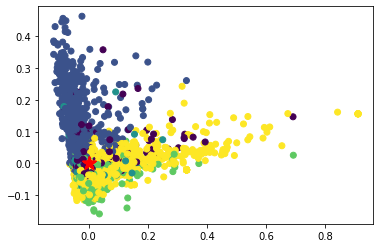

In [ ]:
# task 2 b
k=5
k_means_clustering(k)
top_5_tokens_with_highest_magnitude_and_a_few_documents(k)
graph_the_clusters()


In [ ]:
# task 2 c
from sklearn.metrics import confusion_matrix

# replace the label -1 with the label 2
true_labels = train['category']

cm = confusion_matrix(true_labels, closest_centroids)
print("Confusion matrix:\n", cm)


Confusion matrix:
 [[   0  344  628   27  255  752]
 [   0  252  324   24  339 1045]
 [   0  309  382  127  319  873]
 [   0    0    0    0    0    0]
 [   0    0    0    0    0    0]
 [   0    0    0    0    0    0]]


## Q3 - Comparing Classifiers [10 marks]


0.16654163540885222 0.16654163540885222
Dummy Classifier with strategy='most_frequent': 
 Accuracy: 0.333 
 Precision: 0.778 
 Recall: 0.333 
 F1-Score: 0.167 



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3470557442619427 0.3470557442619427
Dummy Classifier with strategy='stratified': 
 Accuracy: 0.347 
 Precision: 0.347 
 Recall: 0.347 
 F1-Score: 0.347 

0.7653147234053245 0.7653147234053245
Logistic Regression model with one-hot vectorization 
 Accuracy: 0.766 
 Precision: 0.771 
 Recall: 0.766 
 F1-Score: 0.765 

Logistic Regression model with tf-idf vectorization 
 Accuracy: 0.734 
 Precision: 0.737 
 Recall: 0.733 
 F1-Score: 0.734 

Accuracy of SVC Classifier with one-hot vectorization: 
 Accuracy: 0.670 
 Precision: 0.685 
 Recall: 0.670 
 F1-Score: 0.668 



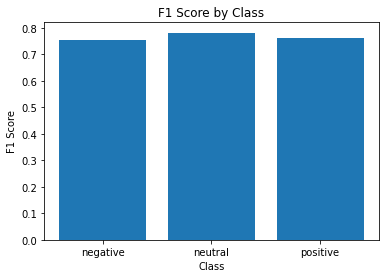

In [ ]:
# part A

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt


train_tweets, validate_tweets = train['clean_text'], validate['clean_text']
train_labels, validate_labels = train['category'], validate['category']

count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

global best_f1, best_f1_scores_per_class
best_f1 = 0
best_f1_scores_per_class = None

for name, model in [("Dummy Classifier with strategy='most_frequent':", DummyClassifier(strategy="most_frequent")),
                  ("Dummy Classifier with strategy='stratified':", DummyClassifier(strategy="stratified")),
                  ("Logistic Regression model with one-hot vectorization", LogisticRegression(max_iter=1000)),
                  ("Logistic Regression model with tf-idf vectorization", LogisticRegression(max_iter=1000)),
                  ("Accuracy of SVC Classifier with one-hot vectorization:", SVC())]:

    if "one-hot vectorization" in name:
        train_tweets_features = count_vectorizer.fit_transform(train_tweets)
        validate_tweets_features = count_vectorizer.transform(validate_tweets)
    else:
        train_tweets_features = tfidf_vectorizer.fit_transform(train_tweets)
        validate_tweets_features = tfidf_vectorizer.transform(validate_tweets)

    model.fit(train_tweets_features, train_labels)
    tweet_pred = model.predict(validate_tweets_features)

    accuracy = accuracy_score(validate_labels, tweet_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(validate_labels, tweet_pred, average='macro', zero_division=1)
    if best_f1<f1:
      best_f1 = f1
      _, _, best_f1_scores_per_class, _ = precision_recall_fscore_support(validate_labels, tweet_pred, average=None)

    print(f"{name} \n Accuracy: {accuracy:.3f} \n Precision: {precision:.3f} \n Recall: {recall:.3f} \n F1-Score: {f1:.3f} \n")

plt.bar(["negative", "neutral", "positive"], best_f1_scores_per_class)
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score by Class')
plt.show()

Multinomial Naive Bayes with one-hot vectorization 

 Accuracy: 0.627 
 Precision: 0.659 
 Recall: 0.627 
 F1-Score: 0.617 



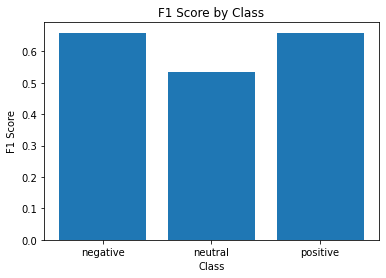



Multinomial Naive Bayes with tf-idf vectorization 

 Accuracy: 0.637 
 Precision: 0.675 
 Recall: 0.638 
 F1-Score: 0.623 



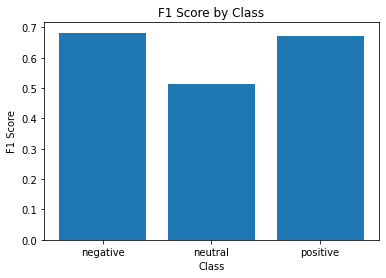

In [ ]:
# part b
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from matplotlib import pyplot as plt

train_tweets, validate_tweets = train['clean_text'], validate['clean_text']
train_labels, validate_labels = train['category'], validate['category']

count_vectorizer = CountVectorizer()

def multinomial_naive_bayes(vectorizer):
  train_tweets_features = vectorizer.fit_transform(train_tweets)
  validate_tweets_features = vectorizer.transform(validate_tweets)

  model = MultinomialNB()
  model.fit(train_tweets_features, train_labels)
  tweet_pred = model.predict(validate_tweets_features)

  accuracy = accuracy_score(validate_labels, tweet_pred)
  precision, recall, f1, _ = precision_recall_fscore_support(validate_labels, tweet_pred, average='macro', zero_division=1)

  print(f" Accuracy: {accuracy:.3f} \n Precision: {precision:.3f} \n Recall: {recall:.3f} \n F1-Score: {f1:.3f} \n")

  _, _, f1_scores_per_class, _ = precision_recall_fscore_support(validate_labels, tweet_pred, average=None)

  plt.bar(["negative", "neutral", "positive"], f1_scores_per_class)
  plt.xlabel('Class')
  plt.ylabel('F1 Score')
  plt.title('F1 Score by Class')
  plt.show()

print("Multinomial Naive Bayes with one-hot vectorization \n")
multinomial_naive_bayes(CountVectorizer())
print("\n\nMultinomial Naive Bayes with tf-idf vectorization \n")
multinomial_naive_bayes(TfidfVectorizer())



## Q4 - Parameter Tuning [5 marks]


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.pipeline import Pipeline

train_tweets, validate_tweets = train['clean_text'], validate['clean_text']
train_labels, validate_labels = train['category'], validate['category']


vectorizer = TfidfVectorizer(sublinear_tf=True, max_features=5000)
model = LogisticRegression(C=40, max_iter=1000)


train_tweets_features = vectorizer.fit_transform(train_tweets)
validate_tweets_features = vectorizer.transform(validate_tweets)

model.fit(train_tweets_features, train_labels)
tweet_pred = model.predict(validate_tweets_features)

accuracy = accuracy_score(validate_labels, tweet_pred)
precision, recall, f1, _ = precision_recall_fscore_support(validate_labels, tweet_pred, average='macro', zero_division=1)

print(f" Accuracy: {accuracy:.3f} \n Precision: {precision:.3f} \n Recall: {recall:.3f} \n F1-Score: {f1:.3f} \n")






 Accuracy: 0.777 
 Precision: 0.778 
 Recall: 0.777 
 F1-Score: 0.777 



## Q5 - Context vectors using BERT [12 marks]


In [ ]:
!pip install transformers
!pip install datasets


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 113.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 16.1 MB/s eta 0:00:00


In [ ]:
# part 5 a (dubious)

import torch
from transformers import RobertaTokenizer, RobertaModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base').to(device)

def encode_document(document):
    encoded_input = tokenizer(document, return_tensors='pt').to(device)
    with torch.no_grad():
        model_output = model(**encoded_input)
    vector = model_output.last_hidden_state[0][0].cpu().numpy()
    return vector

train_tweets = [encode_document(document) for document in train['clean_text']]
validate_tweets = [encode_document(document) for document in validate['clean_text']]

train_labels = train['category']
clf = LogisticRegression(random_state=0, max_iter=1000).fit(train_tweets, train_labels)

tweet_val_pred = clf.predict(validate_tweets)
tweet_val_true = validate['category']

accuracy = accuracy_score(tweet_val_pred, tweet_val_true)
precision, recall, f1, _ = precision_recall_fscore_support(tweet_val_pred, tweet_val_true, average='weighted', zero_division=1)

print(f" Accuracy: {accuracy:.3f} \n Precision: {precision:.3f} \n Recall: {recall:.3f} \n F1-Score: {f1:.3f} \n")



Using device: cuda


loading file vocab.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/merges.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_

NameError: ignored

In [ ]:
#part 5 b (attempt 3)

import torch
from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=1)

train_encodings = tokenizer(train["clean_text"].tolist(), truncation=True, padding=True)
val_encodings = tokenizer(validate["clean_text"].tolist(), truncation=True, padding=True)

class Dataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

train_dataset = Dataset(train_encodings, train["category"].tolist())
val_dataset = Dataset(val_encodings, validate["category"].tolist())

# learning rate = 1e-4, epochs = 1, batch_size = 16 and no weight decay
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
training_args = TrainingArguments(
    output_dir='my_awesome_model',
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.0,
    learning_rate=1e-4,
    #warm up steppies maybe
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

eval_results = trainer.evaluate(eval_dataset=val_dataset)
print(eval_results)

predictions = trainer.predict(val_dataset)
predicted_labels = predictions.predictions.squeeze().round().tolist()
true_labels = validate["category"].tolist()
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted', zero_division=1)
print(f" Accuracy: {accuracy:.3f} \n Precision: {precision:.3f} \n Recall: {recall:.3f} \n F1-Score: {f1:.3f} \n")



loading file vocab.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/merges.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_

Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 2000
  Batch size = 16


***** Running Prediction *****
  Num examples = 2000
  Batch size = 16


{'eval_loss': 0.6672559380531311, 'eval_runtime': 10.1262, 'eval_samples_per_second': 197.507, 'eval_steps_per_second': 12.344, 'epoch': 1.0}
 Accuracy: 0.334 
 Precision: 0.778 
 Recall: 0.334 
 F1-Score: 0.167 



In [ ]:
#part 5 c

import torch
from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=1)

train_encodings = tokenizer(train["clean_text"].tolist(), truncation=True, padding=True)
val_encodings = tokenizer(validate["clean_text"].tolist(), truncation=True, padding=True)

class Dataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

train_dataset = Dataset(train_encodings, train["category"].tolist())
val_dataset = Dataset(val_encodings, validate["category"].tolist())

# learning rate = 1e-4, epochs = 1, batch_size = 16 and no weight decay
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
training_args = TrainingArguments(
    output_dir='my_awesome_model',
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.0,
    learning_rate=1e-4,
    #warm up steppies maybe
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

eval_results = trainer.evaluate(eval_dataset=val_dataset)
print(eval_results)

predictions = trainer.predict(val_dataset)
predicted_labels = predictions.predictions.squeeze().round().tolist()
true_labels = validate["category"].tolist()
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted', zero_division=1)
print(f" Accuracy: {accuracy:.3f} \n Precision: {precision:.3f} \n Recall: {recall:.3f} \n F1-Score: {f1:.3f} \n")

